In [1]:
import itertools
import random
from sympy import *
from sympy.abc import a,b,c,d
from matplotlib import pyplot as plt
import matplotlib as mpl
from deap import base, creator, tools
from deap.algorithms import eaSimple
import numpy as np
import random

np.set_printoptions(suppress=True)

mpl.rcParams['figure.figsize'] = (12.0, 16.0)
mpl.rcParams['font.size'] = 15

In [2]:
def calc_mult(input):
    #input = [[a,b],[c,d]]
    (a,b),(c,d) = input
    return ((a*10 + b) * (c*10 + d))

In [3]:
def assign_optimal(nums):
    sorted_nums = sorted(list(nums))
    return [[sorted_nums[0],sorted_nums[2]],[sorted_nums[1],sorted_nums[3]]]

In [26]:
perms = list(itertools.permutations([0,1,2,3,4,5,6,7,8,9],4))

perms.sort(key = lambda p: calc_mult(assign_optimal(p)))

optimal = [calc_mult(assign_optimal(p)) for p in perms]

In [5]:
perms[0:10]

[(0, 1, 2, 3),
 (0, 1, 3, 2),
 (0, 2, 1, 3),
 (0, 2, 3, 1),
 (0, 3, 1, 2),
 (0, 3, 2, 1),
 (1, 0, 2, 3),
 (1, 0, 3, 2),
 (1, 2, 0, 3),
 (1, 2, 3, 0)]

In [6]:
def assign_random(nums):    
    nums = list(nums)
    random.shuffle(nums)
    return [nums[0:2],nums[2:4]]

In [7]:
def assign_low(nums,A,B,C,D):
    assert len(nums) == 4
    
    ones = []
    tens = []
    
    for num in nums:
        
        #first number
        if len(ones) + len(tens) == 0:
            if num <= A:
                tens.append(num)
            else:
                ones.append(num)
        elif len(ones) + len(tens) == 1:
            if len(ones) == 1:
                if num <= B:
                    tens.append(num)
                else:
                    ones.append(num)
            else:
                if num <= C:
                    tens.append(num)
                else:
                    ones.append(num)
        elif len(ones) + len(tens) == 2:
            if len(ones) == 2:
                tens.append(num)
            elif len(tens) == 2:
                ones.append(num)
            else:
                if num <= D:
                    tens.append(num)
                else:
                    ones.append(num)

        elif len(ones) + len(tens) == 3:
            if len(ones) == 2:
                tens.append(num)
            else:
                ones.append(num)

    return list(zip(tens,ones))
    
    

In [35]:
def plot_performance(A,B,C,D):
    optimal = [calc_mult(assign_optimal(p)) for p in perms]
    strategy = [calc_mult(assign_low(p,A,B,C,D)) for p in perms]
    random = [calc_mult(assign_random(p)) for p in perms]

    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax2.plot(strategy, label='strategy')
    #ax2.plot(random, label='random')
    ax2.plot(optimal, label='optimal')
    ax2.legend()

    ax1.plot([s-o for s,o in zip(strategy,optimal)], label='strategy-optimal')
    ax1.legend()

    plt.show()

In [10]:
def generate_random_parameters():
    return random.randint(0,9)

In [11]:
def mutate_parameters(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.randint(0,9)

    return individual,

In [12]:
def eval_parameters_sum(individual):
    A,B,C,D = individual
    return sum([calc_mult(assign_low(p,A,B,C,D)) for p in perms]),

In [14]:
def eval_parameters_dist_to_optimal_squared(individual):
    A,B,C,D = individual
    return sum([(s-o)**2 for s,o in zip([calc_mult(assign_low(p,A,B,C,D)) for p in perms],
                                        optimal)]),

In [15]:
def stats_get_best_params(stats):
    fit_values = [ind.fitness.values[0] for ind in stats]
    index = fit_values.index(min(fit_values))
    return stats[index]

In [20]:
def stats_get_num_unique_params(stats):
    return len(set(tuple(ind) for ind in stats))

In [21]:
def genetic_search(eval_function,
                   population = 500,
                   hof_size = 5,
                   mating_prob = 0.3,
                   individual_mutate_prob = 0.3,
                   generations=20,
                   tournsize = 3):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    toolbox.register("param_int", generate_random_parameters)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.param_int, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", eval_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate_parameters, indpb=individual_mutate_prob)
    toolbox.register("select", tools.selTournament, tournsize=tournsize)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    best_stats = tools.Statistics(lambda ind: ind)
    best_stats.register("best", stats_get_best_params)
    best_stats.register("uniq", stats_get_num_unique_params)

    all_stats = tools.MultiStatistics(scores=stats, boards=best_stats)

    pop = toolbox.population(n=population)
    hof = tools.HallOfFame(hof_size)

    pop, logbook = eaSimple(pop,
                            toolbox,
                            cxpb=mating_prob,
                            mutpb=individual_mutate_prob,
                            ngen=generations,
                            stats=all_stats,
                            halloffame=hof,
                            verbose=True)

    return hof, pop, logbook

In [22]:
hof1, pop1, logbook1 = genetic_search(eval_parameters_sum)

   	      	       boards       	                  scores                  
   	      	--------------------	------------------------------------------
gen	nevals	best        	uniq	avg        	max        	min       
0  	500   	[4, 6, 1, 4]	490 	7.27089e+06	1.17902e+07	5.5164e+06
1  	251   	[4, 6, 1, 4]	390 	6.56418e+06	1.05873e+07	5.5164e+06
2  	255   	[4, 5, 4, 4]	342 	6.17017e+06	9.38373e+06	5.45928e+06
3  	255   	[4, 5, 4, 4]	273 	5.91216e+06	8.61344e+06	5.45928e+06
4  	281   	[4, 5, 4, 4]	247 	5.82502e+06	8.62915e+06	5.45928e+06
5  	288   	[4, 5, 3, 3]	202 	5.78596e+06	1.04756e+07	5.45925e+06
6  	277   	[4, 5, 3, 4]	164 	5.71429e+06	8.72416e+06	5.42784e+06
7  	279   	[4, 5, 3, 4]	142 	5.6696e+06 	9.26176e+06	5.42784e+06
8  	246   	[4, 5, 3, 4]	131 	5.63704e+06	9.08091e+06	5.42784e+06
9  	242   	[4, 5, 3, 4]	115 	5.61915e+06	9.49764e+06	5.42784e+06
10 	255   	[4, 5, 3, 4]	94  	5.60996e+06	1.17902e+07	5.42784e+06
11 	278   	[4, 5, 3, 4]	96  	5.63426e+06	1.17902e+07	5.42784e+06
12 	244 

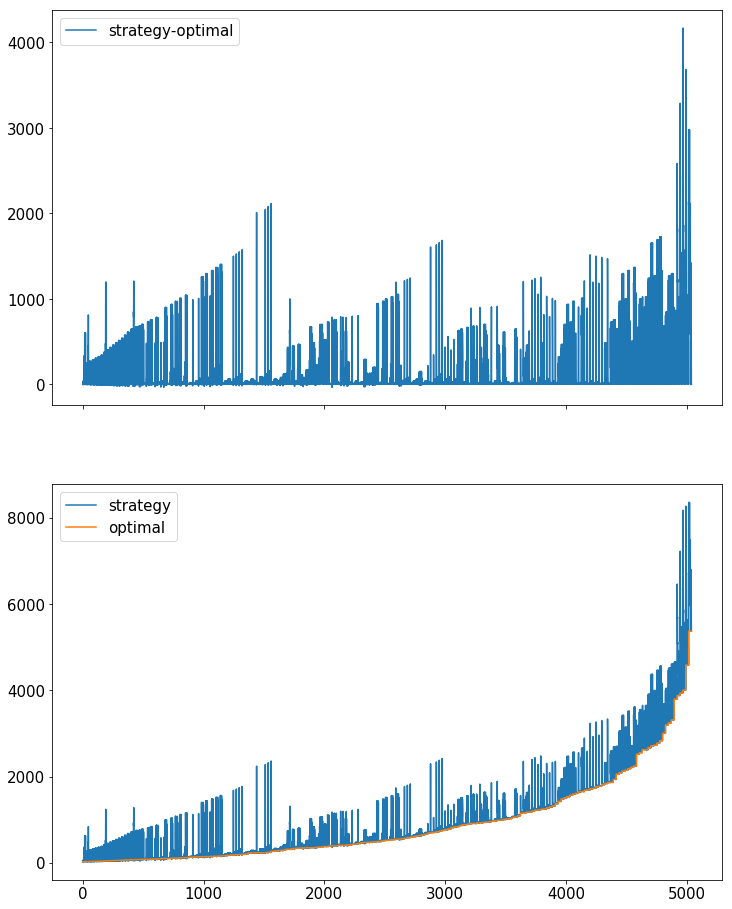

In [36]:
plot_performance(*hof1.items[0])

In [29]:
hof3, pop3, logbook3 = genetic_search(eval_parameters_dist_to_optimal_squared)

   	      	       boards       	                   scores                  
   	      	--------------------	-------------------------------------------
gen	nevals	best        	uniq	avg        	max        	min        
0  	500   	[5, 5, 4, 3]	481 	5.71133e+09	2.41584e+10	9.74103e+08
1  	240   	[5, 5, 4, 3]	389 	3.39759e+09	1.82116e+10	9.74103e+08
2  	262   	[4, 5, 3, 4]	338 	2.50234e+09	1.47698e+10	8.67171e+08
3  	206   	[5, 5, 3, 4]	280 	2.00268e+09	1.15113e+10	8.35223e+08
4  	267   	[5, 5, 3, 4]	260 	1.63048e+09	1.47637e+10	8.35223e+08
5  	251   	[5, 5, 3, 4]	215 	1.48955e+09	1.25361e+10	8.35223e+08
6  	248   	[5, 5, 3, 4]	154 	1.35181e+09	2.41584e+10	8.35223e+08
7  	250   	[5, 5, 3, 4]	132 	1.318e+09  	1.78913e+10	8.35223e+08
8  	257   	[5, 5, 3, 4]	112 	1.21487e+09	1.15344e+10	8.35223e+08
9  	252   	[5, 5, 3, 4]	91  	1.3152e+09 	1.81012e+10	8.35223e+08
10 	254   	[5, 5, 3, 4]	82  	1.21288e+09	1.78282e+10	8.35223e+08
11 	267   	[5, 5, 3, 4]	77  	1.20103e+09	8.95968e+09	8.35223e+08
12 

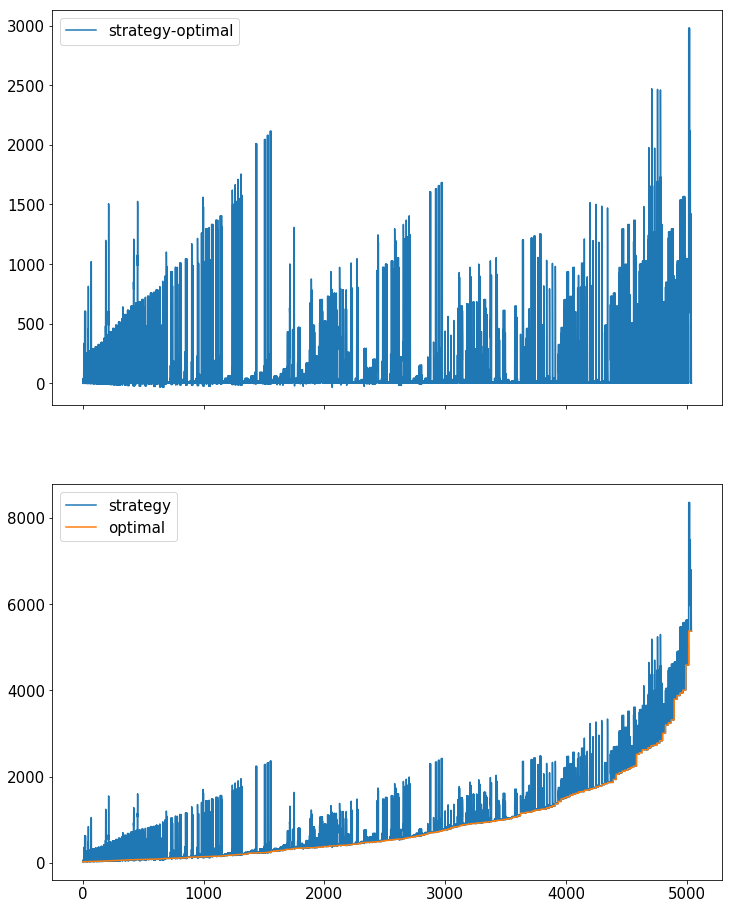

In [38]:
plot_performance(*hof3.items[0])